# 영어 폰트 분류

In [157]:
# 필요한 패키지 임포트
from PIL import Image, ImageDraw, ImageFont
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Rescaling
from tensorflow.keras import layers
from keras.applications import vgg16

import random

## 데이터 생성

In [197]:
# 자음, 모음을 결합하여 만들 수 있는 2350가지의 글자를 한 줄씩 담은 txt파일을 load
# 한 줄씩 읽어와서 리스트로 만듦
charset = [c.strip() for c in open('alphabet.txt','r',encoding='utf-8').readlines()]

# 폰트 데이터가 저장된 경로
FONT_PATH = './eng_fonts'

# 데이터셋이 저장될 경로
OUTPUT_PATH = './eng_datasets'

# 이미지 크기 및 글자 크기 설정
canvas_size = 128
font_size = 80


if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

    
fontList = os.listdir(FONT_PATH)
total_cnt = 0

for label, f in enumerate(fontList):
    if not os.path.exists(f'{OUTPUT_PATH}/{label}'):
        os.mkdir(f'{OUTPUT_PATH}/{label}')
    for cnt, c in enumerate(charset):
        #랜덤으로 r, g, b생성
        r, g, b = random.randint(0, 256), random.randint(0, 256), random.randint(0, 256)
        
        # 3채널로 이미지 생성
        image = Image.new('RGB', (canvas_size, canvas_size), color=(255,255,255))
        drawing = ImageDraw.Draw(image)
        font = ImageFont.truetype(os.path.join(FONT_PATH, f), size=font_size)
        w, h = drawing.textsize(c, font=font)
        drawing.text( ((canvas_size-w)/2, (canvas_size-h)/2), c, fill=((r,g,b)), font=font)
        image.save(os.path.join(f'{OUTPUT_PATH}/{label}',f"{cnt:04d}.jpg"))
        if cnt % 100 == 0:
            print(f"processed {label}\'s {cnt} chars")
    print(f"{label}번째 font data 생성 완료")

processed 0's 0 chars
0번째 font data 생성 완료
processed 1's 0 chars
1번째 font data 생성 완료
processed 2's 0 chars
2번째 font data 생성 완료
processed 3's 0 chars
3번째 font data 생성 완료
processed 4's 0 chars
4번째 font data 생성 완료


C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbo

## data load & train test split

In [198]:
# 매개변수 설정
data_dir='./eng_datasets'
batch_size = 32
img_height = 128
img_width = 128

In [199]:
# train 생성
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred', label_mode='int', # sparse categorical crossentropy니까 int로 가자. categorical넣으면 원핫인코딩 된 label나옴.
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 260 files belonging to 5 classes.
Using 208 files for training.


In [200]:
# validation data 생성
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 260 files belonging to 5 classes.
Using 52 files for validation.


## 데이터 증강 레이어

In [201]:
data_augmentation = Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1, input_shape=(128, 128, 3)),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.9),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
        # 랜덤 회전, 랜덤 대비 조절, 랜덤 줌
    ]
)

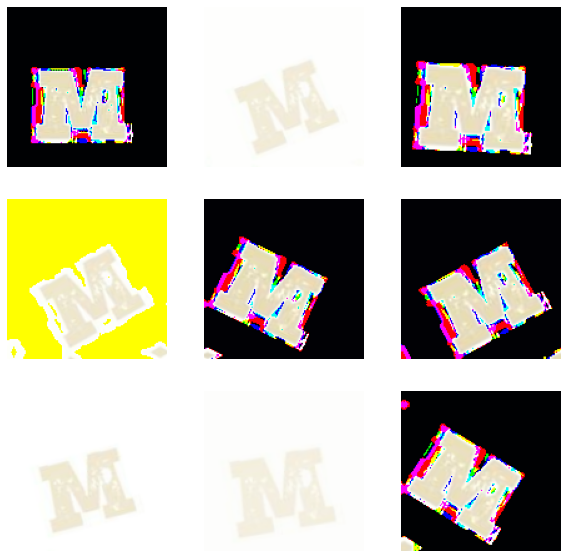

In [202]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
        # data_augmentation 함수를 적용한 이미지를 9개 출력해봄.

## VGG 모델

In [203]:

# transfer model 설정
transfer_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
transfer_model.trainable = False

# data 확장 layer, transfer model 얹어서 vgg_model 만들기.
vgg_model=Sequential()
vgg_model.add(data_augmentation) # 들어온 사진이 데이터 증강 레이어 만남
vgg_model.add(transfer_model) # vgg16모델에 들어감
vgg_model.add(Dropout(0.3))
vgg_model.add(Flatten())
vgg_model.add(Dense(5, activation='softmax', name='output')) # 총 5가지 폰트

vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [204]:
vgg_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_17 (Sequential)   (None, 128, 128, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
output (Dense)               (None, 5)                 40965     
Total params: 14,755,653
Trainable params: 40,965
Non-trainable params: 14,714,688
_________________________________________________________________


In [205]:
v_hist = vgg_model.fit(train_ds, validation_data=val_ds, epochs=30) #비ㅡㅅ하게 나옴..ㅎ 잘 돌린 듯

Epoch 1/30
7/7 [==============================] - 1s 61ms/step - loss: 6.1219 - accuracy: 0.2981 - val_loss: 3.2712 - val_accuracy: 0.4808
Epoch 2/30
7/7 [==============================] - 0s 45ms/step - loss: 3.4687 - accuracy: 0.4567 - val_loss: 1.3813 - val_accuracy: 0.6923
Epoch 3/30
7/7 [==============================] - 0s 43ms/step - loss: 1.8887 - accuracy: 0.6202 - val_loss: 1.5250 - val_accuracy: 0.6731
Epoch 4/30
7/7 [==============================] - 0s 45ms/step - loss: 1.7513 - accuracy: 0.6250 - val_loss: 1.4207 - val_accuracy: 0.7308
Epoch 5/30
7/7 [==============================] - 0s 47ms/step - loss: 1.8978 - accuracy: 0.6154 - val_loss: 1.6755 - val_accuracy: 0.7500
Epoch 6/30
7/7 [==============================] - 0s 45ms/step - loss: 1.1252 - accuracy: 0.6779 - val_loss: 1.2414 - val_accuracy: 0.7692
Epoch 7/30
7/7 [==============================] - 0s 46ms/step - loss: 0.7863 - accuracy: 0.7837 - val_loss: 1.8307 - val_accuracy: 0.7500
Epoch 8/30
7/7 [===========

## acc, loss 그래프

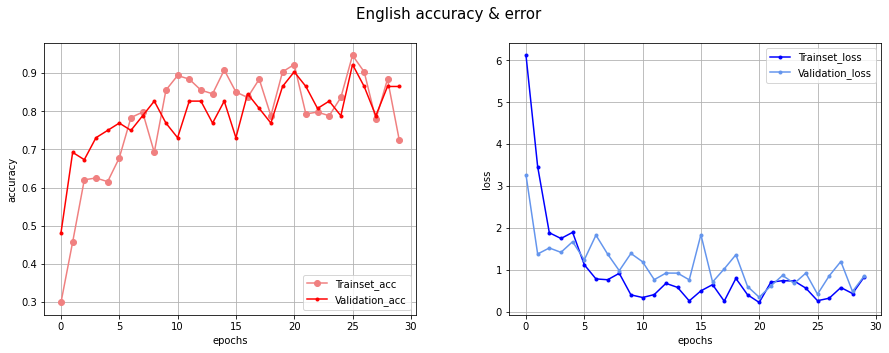

In [206]:
# subplot으로 1행, 2열 설정
# acc와 loss를 분리해서 출력

row=1
col=2

f, axes = plt.subplots(row, col)
f.set_size_inches((15,5))
plt.subplots_adjust(wspace = 0.25, hspace = 0.45)

acc = v_hist.history['accuracy']
loss = v_hist.history['loss']
val_acc= v_hist.history['val_accuracy']
val_loss = v_hist.history['val_loss']

x_len=range(len(loss))

# figure 전체 제목
f.suptitle('English accuracy & error', fontsize = 15)

axes[0].plot(x_len, acc, marker='o', c="lightcoral", label='Trainset_acc')
axes[0].plot(x_len, val_acc, marker='.', c='red', label='Validation_acc')
axes[0].legend(loc='lower right')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].grid(True)


# 일반 acc, loss
axes[1].plot(x_len, loss, marker='.', c="blue", label='Trainset_loss')
axes[1].plot(x_len, val_loss, marker='.', c='cornflowerblue', label='Validation_loss')
axes[1].legend(loc='upper right')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].grid(True)


plt.show()

## best acc, best loss

In [207]:
# training
# 가장 높은 정확도
max_acc = np.max(v_hist.history['accuracy'])
macc_epoch =v_hist.history['accuracy'].index(max_acc) # 제일 높은 acc가 나온 반복 횟수
# 가장 낮은 로스
min_loss = np.min(v_hist.history['loss'])
mloss_epoch = v_hist.history['loss'].index(min_loss)

# validation
# 가장 높은 정확도
t_max_acc = np.max(v_hist.history['val_accuracy'])
t_macc_epoch = v_hist.history['val_accuracy'].index(t_max_acc) # 제일 높은 acc가 나온 반복 횟수
# 가장 낮은 로스
t_min_loss = np.min(v_hist.history['val_loss'])
t_mloss_epoch = v_hist.history['val_loss'].index(t_min_loss)

# 결과 출력
print('VGG 모델')
print()
print('training best acc: {:0.4f} (epoch: {}) \ntraining best loss {:0.4f} (epoch: {})'.format(max_acc, macc_epoch, min_loss, mloss_epoch))
print()
print('validation best acc: {:0.4f} (epoch: {}) \nvalidation best loss {:0.4f} (epoch: {})'.format(t_max_acc, t_macc_epoch, t_min_loss, t_mloss_epoch))


VGG 모델

training best acc: 0.9471 (epoch: 25) 
training best loss 0.2248 (epoch: 20)

validation best acc: 0.9231 (epoch: 25) 
validation best loss 0.3497 (epoch: 20)


## 실제 이미지로 테스트 해보기

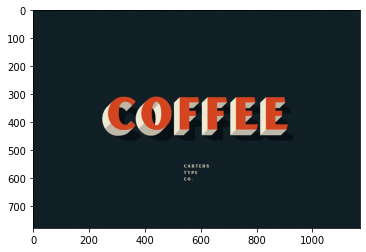

In [208]:
## 이미지 생성
import matplotlib.pyplot as plt
img=plt.imread('coffee.jpg')
plt.imshow(img)

In [209]:
# 글자 디텍션
# Carters Shadow 글씨체 예측해보기

import cv2
import numpy as np
large = cv2.imread('coffee.jpg')
rgb = cv2.pyrDown(large)   # pyrDown : 이미지의 크기를 가로 세로로 절반으로 나눔
small = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)  # 컬러를 흑백으로 변환
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))   # 구조를 타원으로 결정
grad = cv2.morphologyEx(small, cv2.MORPH_GRADIENT, kernel)    #이미지 침식
_, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)   # 임계
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)
# using RETR_EXTERNAL instead of RETR_CCOMP
contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours[0]
mask = np.zeros(bw.shape, dtype=np.uint8)
char_list=[]
for idx in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[idx])
    mask[y:y+h, x:x+w] = 0
    char_list.append(cv2.cvtColor(rgb[y:y+h, x:x+w], cv2.COLOR_BGR2RGB))
    cv2.drawContours(mask, contours, idx, (255, 255, 255), -1)
    r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h)
    if r > 0.45 and w > 8 and h > 8:
        cv2.rectangle(rgb, (x, y), (x+w-1, y+h-1), (0, 255, 0), 2)
# show image with contours rect
#cv2.imshow('rects', rgb)
#cv2.waitKey()

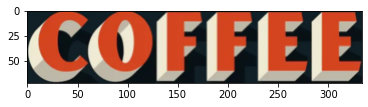

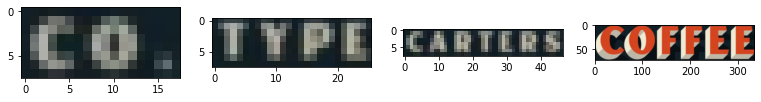

In [210]:
# 글자 디텍션 한 거 자르기

for img in char_list:
    plt.imshow(img)
plt.figure(figsize=(20,20))
for cnt, img in enumerate(char_list):
    plt.subplot(6,6,cnt+1)
    plt.imshow(img)
plt.imshow(char_list[3])


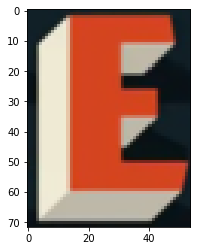

In [211]:
# 'C' 부분만 자르기
plt.imshow(char_list[3][:,int(334/6*5+2):])
c_img = char_list[3][:,int(334/6*5+2):]

In [212]:
## 예측, predict

In [213]:
class_names = fontList.copy()
tmp = np.resize(c_img, (128, 128,3))
print(tmp.shape)
result = vgg_model.predict(np.reshape(tmp,(1, 128, 128, 3)))
print('예측 결과: ',class_names[np.argmax(result)])

# 예측 성공

(128, 128, 3)
예측 결과:  Carters Shadow.ttf
